In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Introduction

We have two goals for our final projects: first, to predict whether or not a hotel booking will be canceled based on various booking information, and second, to better understand the cancellation behavior of hotel customers.

To achieve the first goal, we will create various models using two datasets. The first dataset `hotel_bookings_raw_df` contains information about ~119,000 hotel bookings around the world, including whether it was canceled, the lead time, arrival date, deposit type, hotel type, various economic indicators, and much more. The second dataset `disasters_df` contains information about ~15,000 natural and man-made disasters around the world, including the start date, end date, and country. By creating models trained on features from these two datasets, we will be able to predict whether or not a hotel booking is canceled based on various factors, including intrinsic factors like hotel type and deposit type as well as external factors like disasters, fuel prices, and arrival date.

To achieve the second goal, we plan on using an interpretive model like logistic regression to see the most important features in determining hotel booking cancellations, enabling us to better understand guest cancellation behavior. Additionally, we plan on testing the hypothesis: city hotels have higher cancellation rates than resort hotels using simulation.

This notebook is heavily annotated to make our code understandable. This notebook also serves as a write-up, with an Introduction and Background, Approaches / Methods, Results, and Conclusion and Discussion sections to communicate our findings.  

## EDA

#### Dataset Context

The `hotel_bookings_raw_df` dataset was obtained from Kaggle. It contains both intrinsic information about each hotel bookings and external factors. While most of the instrinsic features are fairly intuitive, some features that need some explaining include:
* `lead_time` - how many days in advance the booking was made
* `hotel` - the hotel type, either `resort` or `city`
* `market_segment` - in which market the booking was made. This includes `Direct` (at the hotel), `Corporate` (through company), `Online`, `TA` (Travel Agent), `Offline TA/TO` (Offline Travel Agent), `Complementary` (Part of some deal), `Groups`, and `Aviation`.
* `deposit_type` - whether the depost was non refundable, refundable, or a direct deposit.
* `customer_type` - type of customer, including `Transient` (guests who book at non-group and non-negotiated rates), `Contract` (a deal between a hotel and a business or corporation to offer special rates to their employees or clients), `Transient-Party` (a group of hotel guests who are traveling alone or with a small group for business or leisure, and who book directly with the hotel or through an online travel agency (OTA)), `Group` (a block of rooms, typically booked and coordinated by a primary group contact, reserved at a discounted rate).

The other features we care about include fuel prices and the number of booking changes.

Note: we do not know what some of the features in the hotel bookings dataset mean, as there isn't much information about the dataset provided on Kaggle. As a result, we will end up dropping these features.

The `disasters_df` dataset was also obtained from Kaggle. It contains information about disasters. The features we care about are the start date, end date, and country in which the disaster occurred.


#### Reading the data and taking a look

Read in the datasets.

In [ ]:
hotel_bookings_raw_df = pd.read_csv("https://raw.githubusercontent.com/timliang4/5450_final_project/refs/heads/main/hotel_bookings_raw.csv")

In [ ]:
disasters_df = pd.read_csv("https://github.com/timliang4/5450_final_project/blob/main/public_emdat_project.csv?raw=true", encoding='ISO-8859-1')

We will drop null values from the hotel bookings dataframe so we won't get undefined columns or datapoints in our EDA visualizations.

In [ ]:
hotel_bookings_raw_df.dropna(inplace=True)

Take a look at each dataset.

In [ ]:
disasters_df.head()

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,Reconstruction Costs ('000 US$),"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update
0,1999-9388-DJI,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,DJI,...,NaN,NaN,NaN,NaN,NaN,NaN,58.111474,"[{""adm1_code"":1093,""adm1_name"":""Ali Sabieh""},{...",2006-03-01,2023-09-25
1,1999-9388-SDN,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,SDN,...,NaN,NaN,NaN,NaN,NaN,NaN,56.514291,"[{""adm1_code"":2757,""adm1_name"":""Northern Darfu...",2006-03-08,2023-09-25
2,1999-9388-SOM,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,SOM,...,NaN,NaN,NaN,NaN,NaN,NaN,56.514291,"[{""adm1_code"":2691,""adm1_name"":""Bay""},{""adm1_c...",2006-03-08,2023-09-25
3,2000-0001-AGO,No,tec-tra-roa-roa,Technological,Transport,Road,Road,NaN,NaN,AGO,...,NaN,NaN,NaN,NaN,NaN,NaN,56.514291,NaN,2004-10-27,2023-09-25
4,2000-0002-AGO,No,nat-hyd-flo-riv,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,AGO,...,NaN,NaN,NaN,NaN,10000.0,17695.0,56.514291,"[{""adm2_code"":4214,""adm2_name"":""Baia Farta""},{...",2005-02-03,2023-09-25


In [ ]:
hotel_bookings_raw_df = hotel_bookings_raw_df.reset_index(drop=True)
hotel_bookings_raw_df["booking_id"] = hotel_bookings_raw_df.index + 1
hotel_bookings_raw_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,INFLATION_CHG,CSMR_SENT,UNRATE,INTRSRT,GDP,FUEL_PRCS,CPI_HOTELS,US_GINI,DIS_INC,booking_id
0,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0.0,93.1,5.3,0.75,18306.960,194.0,0.187566,41.2,41355.0,1
1,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0.0,93.1,5.3,0.75,18306.960,194.0,0.187566,41.2,41355.0,2
2,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0.0,93.1,5.3,0.75,18306.960,194.0,0.187566,41.2,41355.0,3
3,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,0.0,93.1,5.3,0.75,18306.960,194.0,0.187566,41.2,41355.0,4
4,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,-0.1,90.7,5.4,0.75,18193.707,202.6,0.185620,41.2,41290.0,5


#### Checking distribution of target variable

Next, since whether or not a booking was cancelled is our target feature, let's see its distribution in the dataset

In [ ]:
hotel_bookings_raw_df["is_canceled"].value_counts()

,count
is_canceled,
0,62733
1,39980


We want to make sure that the model does better than picking "not cancelled" every single time. This would have an accuracy of $\frac{62733}{62733+39980} \approx 61\%$.

We will now look at the summary statistics for the different variables.

In [ ]:
# Summary statistics
hotel_bookings_raw_df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,INFLATION_CHG,CSMR_SENT,UNRATE,INTRSRT,GDP,FUEL_PRCS,CPI_HOTELS,US_GINI,DIS_INC,booking_id
count,102713.00000,102713.000000,102713.000000,102713.000000,102713.000000,102713.000000,102713.000000,102713.000000,102713.000000,102713.000000,...,102713.000000,102713.000000,102713.000000,102713.000000,102713.000000,102713.000000,102713.000000,102713.000000,102713.000000,102713.000000
mean,0.38924,111.427453,2016.159016,27.331876,15.786716,0.979895,2.590685,1.899750,0.111427,0.007711,...,-0.008554,93.065087,4.826583,1.121411,18795.961462,158.018901,0.177393,41.151587,41971.255304,51357.000000
std,0.48758,107.514109,0.705065,13.289943,8.792788,1.004039,1.907460,0.491305,0.412319,0.097174,...,0.095231,3.245561,0.283444,0.306372,404.615167,21.489998,0.024432,0.049975,433.223454,29650.833437
min,0.00000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.200000,87.200000,4.300000,0.750000,17991.348000,113.400000,0.107059,41.100000,41182.000000,1.000000
25%,0.00000,26.000000,2016.000000,17.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,-0.100000,91.000000,4.700000,1.000000,18425.306000,149.800000,0.165677,41.100000,41680.000000,25679.000000
50%,0.00000,79.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,93.100000,4.900000,1.000000,18775.459000,161.100000,0.183547,41.200000,41850.000000,51357.000000
75%,1.00000,168.000000,2017.000000,38.000000,24.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.100000,96.300000,5.000000,1.250000,19148.194000,171.500000,0.189821,41.200000,42274.000000,77035.000000
max,1.00000,629.000000,2017.000000,53.000000,31.000000,16.000000,41.000000,26.000000,10.000000,10.000000,...,0.100000,98.500000,5.700000,1.750000,19561.896000,204.200000,0.236504,41.200000,42834.000000,102713.000000


We see that 38.9% of the bookings are canceled. We also see a high lead time, meaning that people are booking far in advance.

We will also look at the datatypes of the different variables.

In [ ]:
# Datatypes of the variables
hotel_bookings_raw_df.dtypes

,0
hotel,object
is_canceled,int64
lead_time,int64
arrival_date_year,int64
arrival_date_month,object
arrival_date_week_number,int64
arrival_date_day_of_month,int64
stays_in_weekend_nights,int64
stays_in_week_nights,int64
adults,int64


We see that there are some numerical variables (float64 and int64) and some categorical variables (object). As a result, we will split the EDA plots into those for numerical variables and those for categorical variables.

#### First EDA Plot: Correlation Matrix

For our first EDA plot, we will extract all the numerical features from `hotel_bookings_raw_df` and plot a correlation matrix, just to see which variables correlate well with the target cancelled features, as well as how variables correlate with each other.

Obtain numerical features

In [ ]:
hotel_bookings_numerical_df = hotel_bookings_raw_df.select_dtypes(include=['number']).drop(columns=["booking_id"])

Plot Correlation Matrix

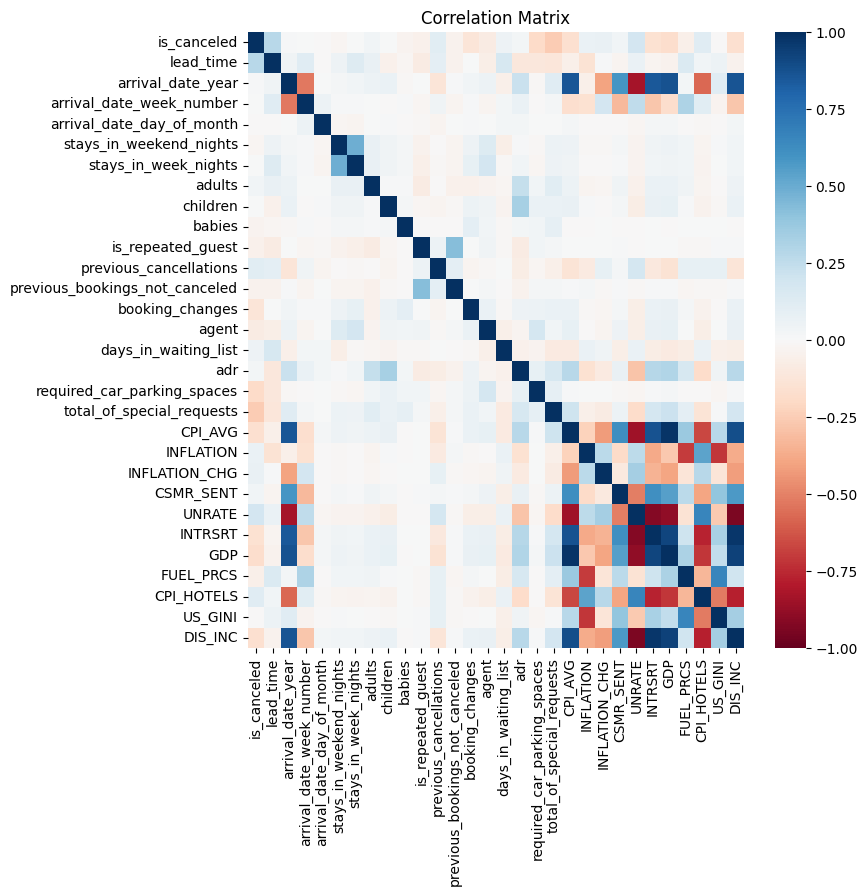

In [ ]:
corr_mat = hotel_bookings_numerical_df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_mat, cmap="RdBu", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

#### First EDA Plot Analysis

First, we can see that the economic factors, like inflation, fuel prices, CPI, and Gini Coefficient all correlate well with each other. This is to be expected, as they all relate to the economy. Another observation is that there aren't any strong correlations between the target variable `is_canceled` and the other variables. This is also to be expected, as cancellations are rare events that don't happen because of one factor. They are often the result of a multitude of factors.

#### Second EDA Plot: Histograms

Next, for the non-numerical features, we can create a countplot for each feature where there are two bars for each category: the bookings that were cancelled in that category and the bookings that there were not cancelled.



Obtain categorical features.

In [ ]:
hotel_bookings_nonnumerical_df = hotel_bookings_raw_df.select_dtypes(exclude=['number']) \
    .drop(["arrival_date_month","reservation_status_date","MO_YR", "country"], axis="columns")

Print categories of each non-numerical feature.

In [ ]:
# print the values of each non numerical features (value_counts()) as comma separated lists
for col in hotel_bookings_nonnumerical_df.columns:
  print(40*"-")
  print(f"{col}: {', '.join(hotel_bookings_nonnumerical_df[col].value_counts().index)}")
print(40*"-")

----------------------------------------
hotel: City Hotel, Resort Hotel
----------------------------------------
meal: BB, HB, SC, Undefined, FB
----------------------------------------
market_segment: Online TA, Offline TA/TO, Groups, Direct, Corporate, Complementary, Aviation
----------------------------------------
distribution_channel: TA/TO, Direct, Corporate, GDS
----------------------------------------
reserved_room_type: A, D, E, F, G, B, C, H
----------------------------------------
assigned_room_type: A, D, E, F, G, B, C, H, I, K
----------------------------------------
deposit_type: No Deposit, Non Refund, Refundable
----------------------------------------
customer_type: Transient, Transient-Party, Contract, Group
----------------------------------------
reservation_status: Check-Out, Canceled, No-Show
----------------------------------------


As discussed previously, we do not know what some of the features' categories mean, as the Kaggle dataset is not very informative. Specifically, we are not sure what the categories for `reserved_room_type`, `assigned_room_type`, or `meal` mean. Therefore, we will drop these features.

Dropping unknown features.

In [ ]:
hotel_bookings_nonnumerical_df.drop(columns=["reserved_room_type","assigned_room_type","meal"],inplace=True)

Finally, we can plot our histogram with the rest of the categorial features.

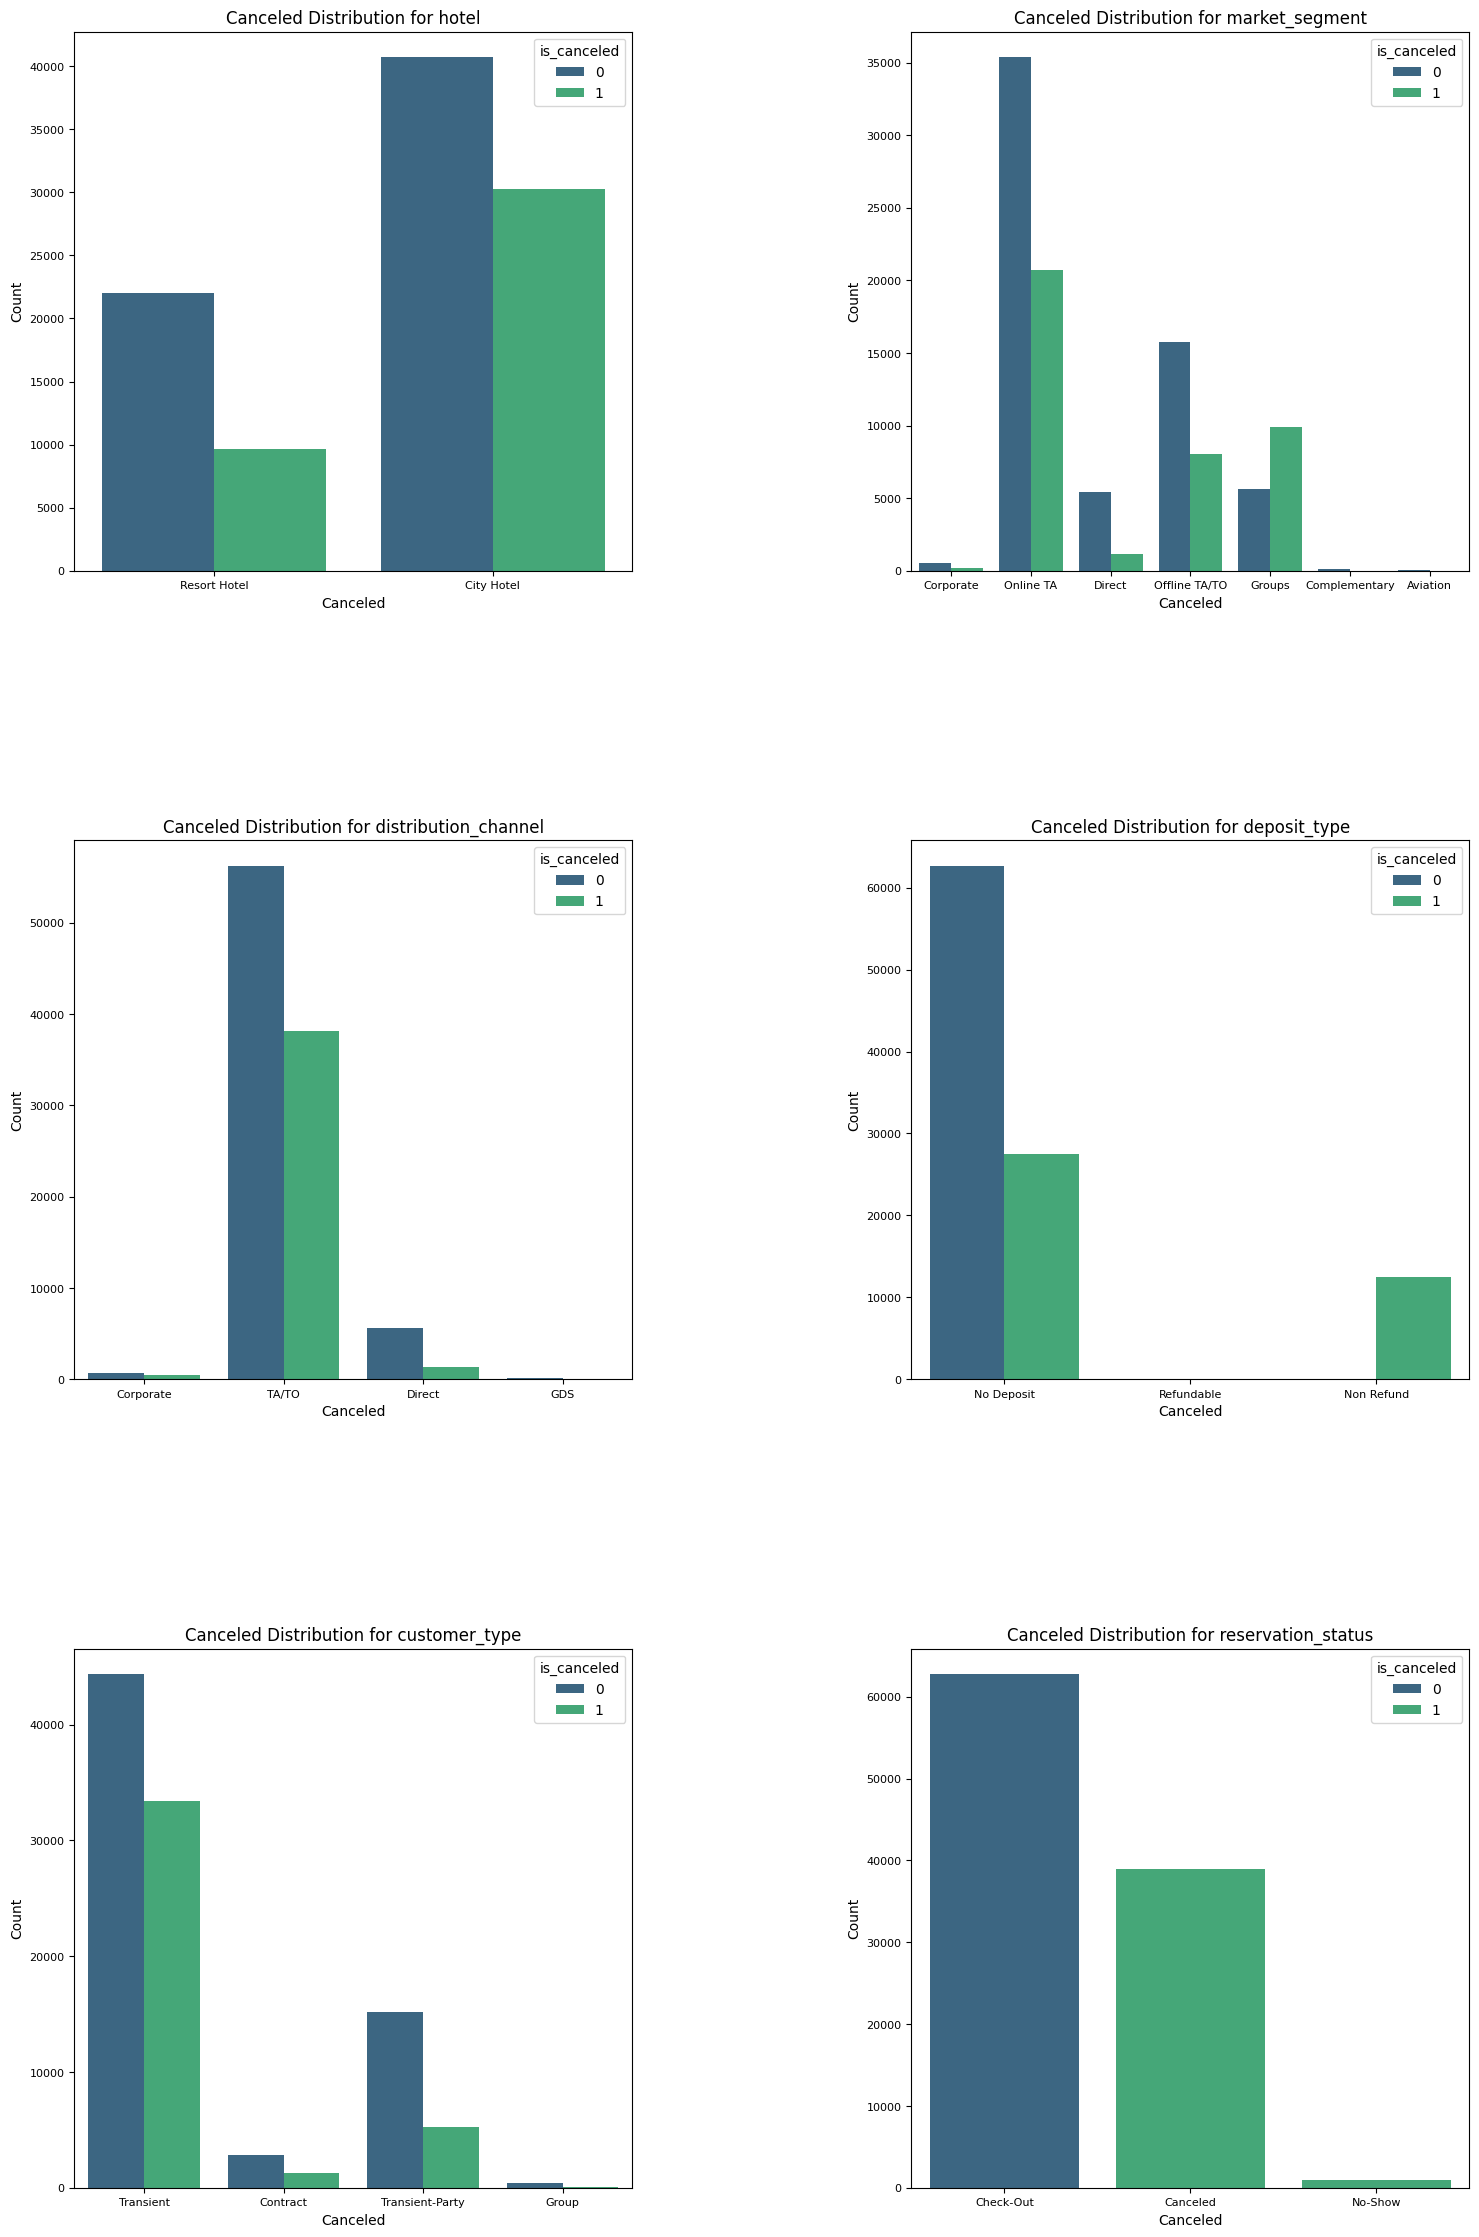

In [ ]:
f, axes = plt.subplots(3, 2, figsize=(18, 28))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i in range(len(hotel_bookings_nonnumerical_df.columns)):
  col = hotel_bookings_nonnumerical_df.columns[i]
  axes[i // 2][i % 2].tick_params(axis='both', which='major', labelsize=8)
  sns.countplot(hotel_bookings_raw_df, x=col, hue="is_canceled", palette="viridis", ax=axes[i // 2][i % 2])
  axes[i // 2][i % 2].set_title(f"Canceled Distribution for {col}")
  axes[i // 2][i % 2].set_xlabel("Canceled")
  axes[i // 2][i % 2].set_ylabel("Count")

#### Second EDA Plot Analysis + `deposit_type` anomaly

Firtly, we can see that the categories of the `distribution_channel` feature are very similar to the categories of the market segment feature, so we can just drop the distribution channel feature.

Next, for the `deposit_type` feature, non refundable hotel bookings have an extremely high cancellation rate, with it being almost 100%. This is an anomaly in our data that we will further investigate below.

Finally, `reservation_status` is a direct indicator of whether or not a hotel booking is canceled or not. Specifically, if a hotel booking is in the `Canceled` or `No Show` category, its cancellation rate is 100%. Otherwise, its cancellation rate is 0%. Therefore, we will drop this feature.

#### Further investigating the `deposit_type` anomaly

To understand why the cancellation rate for non refundable hotel bookings is so high, we extracted the number of non refundable hotel bookings for each country. Clearly, Portugal had almost all the non refundable bookings. Therefore, we can assume that there was something happening in Portugal from 2015 to 2017 that caused its cancellation rate for non refundable hotel bookings to be nearly 100%.

Because the `deposit_type` feature has this anomaly specific to Portugal, we will drop the feature.

In [ ]:
# Number of non refundable hotel bookings for each country
dep_type = hotel_bookings_raw_df
dep_type = dep_type[dep_type["deposit_type"] == "Non Refund"]
dep_type["country"].value_counts()

,count
country,
PRT,12235
ESP,131
DEU,44
GBR,44
POL,37
BEL,15
CN,14
CZE,1
CHE,1


### Third EDA Plot: World Map of Cancellation Rates

For our third EDA plot, we wanted to see if there were any geographical trends for cancellation rates. So, we used the `plotly` library to plot the cancellation rates for each country on a roadmap on a color gradient.

In [ ]:
import plotly.express as px

countries_cancelation_rate = hotel_bookings_raw_df.groupby("country")["is_canceled"].apply(lambda x: x.sum() / x.count()). \
  reset_index(name="num_canceled").rename(columns={"num_canceled":"cancellation_rate"})
fig = px.choropleth(countries_cancelation_rate, locations='country', color='cancellation_rate', hover_name='country',
                    projection='natural earth', title='Hotel Cancellation Rate by Country')
fig.show()

#### Third EDA Plot Analysis

Overall, there seems to be no geographical trends of hotel cancellation rates. Instead, the cancellation rates seem to vary somewhat randomly for each country. Therefore, we will not be using the country as a model feature.

### EDA Takeaways

From our Correlation Matrix, we learned that there were no strong correlations between the `is_canceled` target feature and the other numerical features.

For the countplots of each categorial feature, we learned that the `distribution_channel` feature is very similar to the `market_segment` feature, so we will just drop the `distribution_channel` feature. Additionally, we discovered an anomaly in the `deposit_type` feature, so we will drop this feature. Finally, we noticed that the `reservation_status` feature is a direct indicator of whether or not the hotel booking was canceled, so this feature will be dropped.

Finally, for the world map of cancellation rates, we learned that there are no geographical trends of cancellation rates, which means the `country` feature is not very useful.

## Data Pre-processing & Feature Engineering

We dropped null values at the very start when loading the data in (so our EDA plots wouldn't have undefined values). Therefore, dropping null values isn't necessary in this section.

For handling outliers, we will drop the deposit type feature altogether because the nonrefundable deposit type bookings had almost a 100% cancellation rate, with almost all of them coming from Portugal.

Additionally, no highly correlated variables need to be removed because, as seen from the correlation matrix before, no variables correlate highly with the target variable.

For the imbalanced canceled to non-canceled hotel booking proportions, we will employ stratified sampling (done in a later cell).

Firstly, we will filter for the features we think are important. As discussed in the EDA section, we do not understand some of categorial features, such as the room type. Additionally, the `distribution_channel` and `reservation_status` features are similar to other features. Thus, we will only include the `hotel` (hotel type), `market_segment`, and `customer_type` features.

For numerical features, we think `lead_time` (how far in advance the booking was made) is important because the further in advance the booking was made, the more time the booker has to cancel. We also think `FUEL_PRCS` is important because it directly impacts travel costs, which would impact hotel cancellations. Finally, we think the `booking_changes` feature is important because more booking changes could mean the hotel is more flexible, decreasing the likelihood of cancellation.

Finally, we think disasters could impact cancellation rates, as people who booked hotel stays in advance will cancel their bookings when they hear about a disaster in the hotel's country. Thus, we will keep the arrival date, year, and month and country columns to link with the disasters dataframe. They will not be used as features in our model.

In [ ]:
to_include = ["is_canceled", "lead_time", "arrival_date_year", "arrival_date_month", "arrival_date_day_of_month", "FUEL_PRCS",
              "booking_changes", "hotel", "market_segment", "customer_type", "country", "booking_id"]

Filtering for desired columns

In [ ]:
hotel_bookings_df = hotel_bookings_raw_df[to_include]

Next, we will convert the arrival date, year and month columns into a single column with the arrival date as a datetime object. This will make it easier to merge this dataframe with the disasters dataframe.

In [ ]:
# convert arrival time columns into datetime column
hotel_bookings_df["arrival_date_year"] = hotel_bookings_df["arrival_date_year"].astype(str)
hotel_bookings_df["arrival_date_month"] = hotel_bookings_df["arrival_date_month"].astype(str)
hotel_bookings_df["arrival_date_day_of_month"] = hotel_bookings_df["arrival_date_day_of_month"].astype(str)
# Combine arrival_date_year, arrival_date_month, and arrival_date_day_of_month
hotel_bookings_df["arrival_date"] = hotel_bookings_df["arrival_date_year"] + "-" + hotel_bookings_df["arrival_date_month"] + "-" + hotel_bookings_df["arrival_date_day_of_month"]
hotel_bookings_df["arrival_date"] = pd.to_datetime(hotel_bookings_df["arrival_date"])
hotel_bookings_df.drop(columns=["arrival_date_year", "arrival_date_month", "arrival_date_day_of_month"], inplace=True)
hotel_bookings_df = hotel_bookings_df.dropna(how='any',axis=0)
hotel_bookings_df

<ipython-input-20-af3365412aca>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-af3365412aca>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-af3365412aca>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-af33654

,is_canceled,lead_time,FUEL_PRCS,booking_changes,hotel,market_segment,customer_type,country,booking_id,arrival_date
0,0,13,194.0,0,Resort Hotel,Corporate,Transient,GBR,1,2015-07-01
1,0,14,194.0,0,Resort Hotel,Online TA,Transient,GBR,2,2015-07-01
2,0,14,194.0,0,Resort Hotel,Online TA,Transient,GBR,3,2015-07-01
3,0,9,194.0,0,Resort Hotel,Direct,Transient,PRT,4,2015-07-01
4,1,85,202.6,0,Resort Hotel,Online TA,Transient,PRT,5,2015-07-01
...,...,...,...,...,...,...,...,...,...,...
102708,0,23,204.2,0,City Hotel,Offline TA/TO,Transient,BEL,102709,2017-08-30
102709,0,102,204.2,0,City Hotel,Online TA,Transient,FRA,102710,2017-08-31
102710,0,34,204.2,0,City Hotel,Online TA,Transient,DEU,102711,2017-08-31
102711,0,109,204.2,0,City Hotel,Online TA,Transient,GBR,102712,2017-08-31


We will also convert the start and end year, month, and day of each disaster into datatime objects. We will also rename the ISO column (the country's three letter code) to `country`. This will make the merging process easier.

In [ ]:
disasters_filtered_df = disasters_df[["ISO", "Start Year", "Start Month", "Start Day", "End Year", "End Month", "End Day"]]
# filter so the disaster start dates are between 2015 and 2017
disasters_filtered_df = disasters_filtered_df[(disasters_filtered_df["Start Year"] >= 2015) & (disasters_filtered_df["Start Year"] <= 2017)]
disasters_cleaned_df = disasters_filtered_df.dropna(how='any',axis=0)
# parse start month, day and year into datetime object
disasters_cleaned_df["Start Year"] = disasters_cleaned_df["Start Year"].astype(int)
disasters_cleaned_df["Start Month"] = disasters_cleaned_df["Start Month"].astype(int)
disasters_cleaned_df["Start Day"] = disasters_cleaned_df["Start Day"].astype(int)
# Rename the columns to 'year', 'month', and 'day' for pd.to_datetime
disasters_cleaned_df = disasters_cleaned_df.rename(columns={"Start Year": "year", "Start Month": "month", "Start Day": "day"})
disasters_cleaned_df["Start Datetime"] = pd.to_datetime(disasters_cleaned_df[["year", "month", "day"]])
disasters_cleaned_df.drop(columns=["year", "month", "day"], inplace=True)
# do the same for end mobt, day, and year
disasters_cleaned_df["End Year"] = disasters_cleaned_df["End Year"].astype(int)
disasters_cleaned_df["End Month"] = disasters_cleaned_df["End Month"].astype(int)
disasters_cleaned_df["End Day"] = disasters_cleaned_df["End Day"].astype(int)
# Rename the columns to 'year', 'month', and 'day' for pd.to_datetime
disasters_cleaned_df = disasters_cleaned_df.rename(columns={"End Year": "year", "End Month": "month", "End Day": "day"})
disasters_cleaned_df["End Datetime"] = pd.to_datetime(disasters_cleaned_df[["year", "month", "day"]])
disasters_cleaned_df.drop(columns=["year", "month", "day"], inplace=True)
disasters_cleaned_df.rename(columns={'ISO': 'country'}, inplace=True)
disasters_cleaned_df

<ipython-input-21-51550f7cd8eb>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-21-51550f7cd8eb>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-21-51550f7cd8eb>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,country,Start Datetime,End Datetime
10519,BOL,2015-01-15,2015-01-31
10584,CPV,2015-01-09,2015-01-09
10585,LBN,2015-01-06,2015-01-10
10586,PSE,2015-01-07,2015-01-10
10587,SYR,2015-01-07,2015-01-11
...,...,...,...
12241,SDN,2017-06-30,2017-08-14
12243,BRA,2017-08-24,2017-08-24
12244,IDN,2017-11-19,2017-11-24
12247,ITA,2017-06-03,2017-06-03


#### Feature Engineering the `num_disasters` column

As discussed before, we think disasters can be a good indicator of whether a hotel booking will be canceled. Thus, we will create a `num_disasters` column by joining the hotel bookings and disasters dataframe. Below is an Entity Relationship diagram showing the relationship between the hotel booking entity and disaster entity.

![](https://github.com/timliang4/5450_final_project/blob/main/final_project_ER_diagram.png?raw=true)

#### Joining the Dataframes

To engineer this feature, we will first merge the disasters dataframe and the hotel bookings dataframe using Pandas `merge` on the `country` column. This will create a new `merged_df` dataframe where each hotel booking has every disaster that occurred in the same country as it. For each hotel booking's disasters, we will filter for the disasters that occurred during the hotel booking's arrival date, count the number of such disasters, and place them in a `num_disasters` column. Any hotel bookings that had no disasters occurring will have `null` for the `num_disasters` column, so we will fill the nulls with `0`.

In [ ]:
merged_df = pd.merge(
    hotel_bookings_df, disasters_cleaned_df,
    on='country', how='left'
)

merged_df['num_disasters'] = (
    (merged_df['arrival_date'] >= merged_df['Start Datetime']) &
    (merged_df['arrival_date'] <= merged_df['End Datetime'])
)

disaster_count = merged_df.groupby(['booking_id'])['num_disasters'].sum().reset_index()
hotel_bookings_df = pd.merge(hotel_bookings_df, disaster_count, on="booking_id", how='left')

Checking the `num_disaster` values for hotel bookings. The values seem reasonable.

In [ ]:
hotel_bookings_df["num_disasters"].value_counts().reset_index(drop=True)

,count
0,97873
1,3774
2,882
3,182
4,2


#### Performing a Train Test Splice with Stratified Sampling

As discussed previously, the proportion of canceled hotel bookings is ~39%. To ensure that the train and test sets have the same proportion of canceled hotel bookings we will employ Sci-Kit Learn's stratified keyword argument.

We will also have a 80/20 train test split and drop the country and arrival date columns, as they were just used for engineering the `num_disasters` feature.

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(hotel_bookings_df.drop(columns=["country", "arrival_date", "is_canceled", "booking_id"]),
                                                    hotel_bookings_df['is_canceled'], test_size=0.2, random_state=42, stratify=hotel_bookings_df['is_canceled'])

#### Applying Standard Scaler to Numerical Columns

As explained previously, we included the `lead_time`, `FUEL_PRCS`, and `booking_changes` numerical columns because we think they are important. Additionally, we engineered the `num_disasters` column. To ensure that one feature doesn't have a larger influence on models than the others, we will apply the standard scaler to all of them.

In [ ]:
# apply standard scaler to numerical columns
num_cols = ["lead_time", "FUEL_PRCS", "booking_changes", "num_disasters"]
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### One-Hot Encoding the Categorical Columns

We will One-Hot Encode the categorial features because there is no intrinsic ordering in any of the categories.

In [ ]:
to_encode = ["hotel", "market_segment", "customer_type"]

# one hot encode non numerical features
enc = OneHotEncoder(sparse_output = False)
encoded_binary_df = pd.DataFrame(enc.fit_transform(X_train[to_encode]), columns=enc.get_feature_names_out()).reset_index(drop=True)
X_train[encoded_binary_df.columns] = encoded_binary_df
X_train.drop(columns=to_encode, inplace=True)
encoded_binary_df = pd.DataFrame(enc.transform(X_test[to_encode]), columns=enc.get_feature_names_out()).reset_index(drop=True)
X_test[encoded_binary_df.columns] = encoded_binary_df
X_test.drop(columns=to_encode, inplace=True)

# Approach/Methods

We plan on creating supervised classification models. We are considering using logistic regression, decision trees, and random forest classifier models with the economic indicators and information about the hotel stay as the features and whether the booking is canceled as the target variable. We can do a hypothesis test on whether city hotels have a higher cancellation rate than resort hotels. $H_0$: (city hotel cancellation rate) - (resort hotel cancellation rate) = 0. $H_1$: (city hotel cancellation rate) - (resort hotel cancellation rate) ≠ 0. The test statistic is (city hotel cancellation rate) - (resort hotel cancellation rate). We can use simulations to test this by assuming the null hypothesis, then simulating according to the combined ratios, then calculating the empirical p-value by comparing the simulation results to the observed results.


## Models

Our Baseline Model is Logistic Regression, both the weighted and unweighted variations.

For our more advanced models, we will try Decision Trees with and without Pruning, as well as Random Forest Classifiers with and without hyperparameter tuning. We will use grid search and cross validation to tune the pruning parameter in the decision trees, while we will use grid search and cross validation to tune the number of estimators and the maximum number of features in the random forest.



### Baseline Models

Our baseline models are the logistic regression models, both the unweighted and the weighted versions.

In [ ]:
# Logistic Regression Models
%%time
unweighted_lrg = LogisticRegression()
unweighted_lrg.fit(X_train, y_train)
unweighted_lrg

CPU times: user 448 ms, sys: 221 ms, total: 669 ms
Wall time: 389 ms


LogisticRegression()

In [ ]:
# Logistic Regression Models
%%time
weighted_lrg = LogisticRegression(class_weight='balanced')
weighted_lrg.fit(X_train, y_train)
weighted_lrg

CPU times: user 508 ms, sys: 311 ms, total: 819 ms
Wall time: 480 ms


LogisticRegression(class_weight='balanced')

We will now evaluate this model using the following metrics:

* Accuracy = $\frac{TP+TN}{TP+FN+FP+TN}$
* Recall/Sensitivity = $\frac{TP}{TP+FN}$ - intuitively, recall is the ability of the classifier to find all the positive samples. A model with high recall has few false negatives, and thus fewer positive cases may be missed.
* Precision = $\frac{TP}{TP+FP}$ - intuitively, precision is the ability of the classifier to not label a negative sample as positive. A model with high precision has few false positives, and thus fewer negative cases that are misidentified as positive.

In [ ]:
def compute_accuracy(y_true, y_pred):
  TP = sum((y_true == 1) & (y_pred == 1))
  TN = sum((y_true == 0) & (y_pred == 0))
  FP = sum((y_true == 0) & (y_pred == 1))
  FN = sum((y_true == 1) & (y_pred == 0))
  return (TP + TN) / (TP + TN + FP + FN)

def compute_recall(y_true, y_pred):
  TP = sum((y_true == 1) & (y_pred == 1))
  TN = sum((y_true == 0) & (y_pred == 0))
  FP = sum((y_true == 0) & (y_pred == 1))
  FN = sum((y_true == 1) & (y_pred == 0))
  return TP / (TP + FN) if (TP + FN) > 0 else 0.0

def compute_precision(y_true, y_pred):
  TP = sum((y_true == 1) & (y_pred == 1))
  TN = sum((y_true == 0) & (y_pred == 0))
  FP = sum((y_true == 0) & (y_pred == 1))
  FN = sum((y_true == 1) & (y_pred == 0))
  return TP / (TP + FP) if (TP + FP) > 0 else 0.0

Now, we will evaluate how good our baseline models are.

In [ ]:
# Calculating the training accuracy, recall, and precision for the unweighted model
unweighted_lrg_y_train_pred = unweighted_lrg.predict(X_train)

unweighted_lrg_train_acc = compute_accuracy(y_train, unweighted_lrg_y_train_pred)

unweighted_lrg_train_recall = compute_recall(y_train, unweighted_lrg_y_train_pred)

unweighted_lrg_train_precision = compute_precision(y_train, unweighted_lrg_y_train_pred)


print(f'Unweighted Logistic Regression Training Accuracy: {unweighted_lrg_train_acc}')

print(f'Unweighted Logistic Regression Training Recall: {unweighted_lrg_train_recall}')

print(f'Unweighted Logistic Regression Training Precision: {unweighted_lrg_train_precision}')

Unweighted Logistic Regression Training Accuracy: 0.7182183278568821
Unweighted Logistic Regression Training Recall: 0.4569784892446223
Unweighted Logistic Regression Training Precision: 0.7164003529065778


In [ ]:
%%time
# Calculating the testing accuracy, recall, and precision for the unweighted model
unweighted_lrg_y_test_pred = unweighted_lrg.predict(X_test)

unweighted_lrg_test_acc = compute_accuracy(y_test, unweighted_lrg_y_test_pred)

unweighted_lrg_test_recall = compute_recall(y_test, unweighted_lrg_y_test_pred)

unweighted_lrg_test_precision = compute_precision(y_test, unweighted_lrg_y_test_pred)


print(f'Unweighted Logistic Regression Testing Accuracy: {unweighted_lrg_test_acc}')

print(f'Unweighted Logistic Regression Testing Recall: {unweighted_lrg_test_recall}')

print(f'Unweighted Logistic Regression Testing Precision: {unweighted_lrg_test_precision}')

Unweighted Logistic Regression Testing Accuracy: 0.7119700141167308
Unweighted Logistic Regression Testing Recall: 0.443471735867934
Unweighted Logistic Regression Testing Precision: 0.7073608617594255
CPU times: user 60.3 ms, sys: 28.4 ms, total: 88.8 ms
Wall time: 59.9 ms


#### Baseline Unweighted LR Model Scores Reflection

While the unweighted logistic regression model exhibits decent accuracy and precision scores of `~70%` on the test set, its recall score is not good: `~40%`. This indicates that the model or system is missing a significant portion of relevant items and patterns.

Let's see if weighted LR is any better:

In [ ]:
# Calculating the training accuracy, recall, and precision for the weighted model
weighted_lrg_y_train_pred = weighted_lrg.predict(X_train)

weighted_lrg_train_acc = compute_accuracy(y_train, weighted_lrg_y_train_pred)

weighted_lrg_train_recall = compute_recall(y_train, weighted_lrg_y_train_pred)

weighted_lrg_train_precision = compute_precision(y_train, weighted_lrg_y_train_pred)


print(f'Weighted Logistic Regression Training Accuracy: {weighted_lrg_train_acc}')

print(f'Weighted Logistic Regression Training Recall: {weighted_lrg_train_recall}')

print(f'Weighted Logistic Regression Training Precision: {weighted_lrg_train_precision}')

Weighted Logistic Regression Training Accuracy: 0.6779603261530972
Weighted Logistic Regression Training Recall: 0.6448849424712356
Weighted Logistic Regression Training Precision: 0.5772739994402463


In [ ]:
%%time
# Calculating the testing accuracy, recall, and precision for the weighted model
weighted_lrg_y_test_pred = weighted_lrg.predict(X_test)

weighted_lrg_test_acc = compute_accuracy(y_test, weighted_lrg_y_test_pred)

weighted_lrg_test_recall = compute_recall(y_test, weighted_lrg_y_test_pred)

weighted_lrg_test_precision = compute_precision(y_test, weighted_lrg_y_test_pred)


print(f'Weighted Logistic Regression Testing Accuracy: {weighted_lrg_test_acc}')

print(f'Weighted Logistic Regression Testing Recall: {weighted_lrg_test_recall}')

print(f'Weighted Logistic Regression Testing Precision: {weighted_lrg_test_precision}')

Weighted Logistic Regression Testing Accuracy: 0.6753638709049311
Weighted Logistic Regression Testing Recall: 0.6364432216108054
Weighted Logistic Regression Testing Precision: 0.5749632809851994
CPU times: user 55.3 ms, sys: 42.8 ms, total: 98 ms
Wall time: 53.4 ms


#### Baseline Weighted LR Model Scores Reflection

The weighted LR model exhibits worse precision and accuracy scores, but its recall is much higher than the unweighted LR model, around `63%`.

For more advanced models, we will want to have significantly higher precision, accuracy, and recall scores to ensure hotels will be able to accurately predict hotel cancellations with minimal false positives and negatives. However, these LR models are a good baseline and can also provide some insights about feature importance.

### Feature Importance

The Unweighted Logistic Regression Model has the highest precision and accuracy scores. Therefore, we can look at the model's coefficients to determine which features are the most important.

In [ ]:
coefficients = unweighted_lrg.coef_[0]

# Create a dataframe to display feature importance
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
feature_importance

,Feature,Importance
0,market_segment_Groups,1.310442
1,customer_type_Transient,0.991729
2,lead_time,0.657288
3,market_segment_Corporate,0.301861
4,customer_type_Contract,0.033662
5,num_disasters,-0.003300
6,hotel_City Hotel,-0.129866
7,market_segment_Aviation,-0.161487
8,FUEL_PRCS,-0.189486
9,market_segment_Offline TA/TO,-0.292239


# Decision Tree

#### Justification

The first advanced model we will try is the decision tree. We choose this model because we expect that hotels with similar cases should have similar results in terms of whether the booking is canceled or not. Therefore, decision trees can often capture the similar cases that hotels experience through its tree structure, which could improve accuracy, recall, and most importantly, precision.

Additionally, Decision trees do not require assumptions about linear relationships between features and the target variable. This is particularly useful when predicting hotel cancellations, as there are likely complex, non-linear interactions between various factors.

First, we will try training a basic Decision Tree with a max depth of 5, so as not to overfit the data:

In [ ]:
# Decision tree with a max depth of 5
%%time
dt_np_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_np_clf.fit(X_train, y_train)

CPU times: user 109 ms, sys: 11.8 ms, total: 121 ms
Wall time: 109 ms


DecisionTreeClassifier(max_depth=5, random_state=42)

Visualizing the Decision Tree to see if the splits make sense.

In [ ]:
# Visualize the decision tree
from sklearn import tree
text_representation = tree.export_text(dt_np_clf, feature_names=list(X_train.columns))
print(text_representation)

|--- lead_time <= -0.80
|   |--- lead_time <= -0.97
|   |   |--- hotel_City Hotel <= 0.50
|   |   |   |--- FUEL_PRCS <= 0.48
|   |   |   |   |--- market_segment_Offline TA/TO <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- market_segment_Offline TA/TO >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- FUEL_PRCS >  0.48
|   |   |   |   |--- market_segment_Groups <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- market_segment_Groups >  0.50
|   |   |   |   |   |--- class: 1
|   |   |--- hotel_City Hotel >  0.50
|   |   |   |--- FUEL_PRCS <= -1.94
|   |   |   |   |--- customer_type_Transient-Party <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- customer_type_Transient-Party >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- FUEL_PRCS >  -1.94
|   |   |   |   |--- lead_time <= -0.99
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- lead_time >  -0.99
|   |   |   |   |   |--- class: 0
|   |--- lead_time >  -0.97
|   |   |--- b

The splits in the above decision tree see to make sense. The top splits are supposed to be the most important ones, and the top splits for this decision tree are lead time and market segment, both of which were important features for our LR model. Thus, it seems that our Decision Tree is on the right track.

In [ ]:
# Computing the training accuracies
dt_np_y_train_pred = dt_np_clf.predict(X_train)

dt_np_train_acc = compute_accuracy(y_train, dt_np_y_train_pred)

dt_np_train_recall = compute_recall(y_train, dt_np_y_train_pred)

dt_np_train_precision = compute_precision(y_train, dt_np_y_train_pred)

print(f'Training Accuracy: {dt_np_train_acc}')

print(f'Training Recall: {dt_np_train_recall}')

print(f'Training Precision: {dt_np_train_precision}')

Training Accuracy: 0.734805890227577
Training Recall: 0.4112368684342171
Training Precision: 0.8162973996152175


In [ ]:
# Compute the testing accuracies
%%time
dt_np_y_test_pred = dt_np_clf.predict(X_test)

dt_np_test_acc = compute_accuracy(y_test, dt_np_y_test_pred)

dt_np_test_recall = compute_recall(y_test, dt_np_y_test_pred)

dt_np_test_precision = compute_precision(y_test, dt_np_y_test_pred)

print(f'Test Accuracy: {dt_np_test_acc}')

print(f'Test Recall: {dt_np_test_recall}')

print(f'Test Precision: {dt_np_test_precision}')

Test Accuracy: 0.7292995180840189
Test Recall: 0.4000750375187594
Test Precision: 0.8072167549835982
CPU times: user 27.8 ms, sys: 1.02 ms, total: 28.9 ms
Wall time: 28.2 ms


#### Reflection on Decision Tree Scores

The Decision Tree performs better than both baseline Logistic Regression models in terms of both accuracy and precision. In fact, the precision (the most important metric for us), is above 80%. However, the recall for the decision tree is worse than the weight Logistic Regression model, which means that our decision tree is not capturing patterns in the data. This could potentially be caused by the decision tree overfitting the train data and not generalizing to the test data.

### Decision Tree with Hyperparameter Tuning for Pruning

Now, we will try a decision tree with pruning. The pruning will make sure that we do not overfit the training data, and the algorithm is made to minimize the test loss of the decision trees.

In [ ]:
from re import X
from sklearn import tree
def best_ccp_alpha_f1(X_train, y_train):
    """
    Returns the pruning parameter (best_ccp_alpha) with the highest cross-validation F1 score along with the
    five cross-validation F1 scores corresponding (cv_f1_scores).

    Args:
        train_df

    Returns:
        best_ccp_alpha: the tuned best ccp alpha value
        cv_f1_scores: the five cross-validation F1 scores

    """
    ccp_alphas = np.linspace(0, 0.5, 10)
    cv_f1_scores = []
    for ccp_alpha in ccp_alphas:
      clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
      cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='average_precision')
      cv_f1_scores.append(np.mean(cv_scores))
    best_index = np.argmax(cv_f1_scores)
    best_ccp_alpha = ccp_alphas[best_index]
    best_cv_f1_score = cv_f1_scores[best_index]

    return best_ccp_alpha, cv_f1_scores

def refit_and_predict(X_train, y_train, X_test, y_test, best_ccp_alpha):
    """
    Fit a decision tree classifier on the training data using the best_ccp_alpha value and output the predictions on the
    test set.

    Args:
        train_df
        test_df
        best_ccp_alpha

    Returns:
        y_test_pred: The predicted values for the test set
    """
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_ccp_alpha)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    text_representation = tree.export_text(clf)
    print(text_representation)

    return y_test_pred, text_representation

In [ ]:
%%time
# Training the decision trees on the training tests
best_ccp_alpha, cv_f1_scores = best_ccp_alpha_f1(X_train, y_train)
dt_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_ccp_alpha)
dt_clf.fit(X_train, y_train)

CPU times: user 40.4 s, sys: 54.9 ms, total: 40.5 s
Wall time: 40.6 s


DecisionTreeClassifier(random_state=42)

Visualizing the Pruned Decision Tree

In [ ]:
# Plot the decision tree
text_representation = tree.export_text(dt_clf, feature_names=list(X_train.columns))
print(text_representation)

|--- lead_time <= -0.80
|   |--- lead_time <= -0.97
|   |   |--- hotel_City Hotel <= 0.50
|   |   |   |--- FUEL_PRCS <= 0.48
|   |   |   |   |--- market_segment_Offline TA/TO <= 0.50
|   |   |   |   |   |--- booking_changes <= 0.48
|   |   |   |   |   |   |--- FUEL_PRCS <= 0.35
|   |   |   |   |   |   |   |--- FUEL_PRCS <= 0.19
|   |   |   |   |   |   |   |   |--- lead_time <= -0.99
|   |   |   |   |   |   |   |   |   |--- lead_time <= -1.03
|   |   |   |   |   |   |   |   |   |   |--- FUEL_PRCS <= -1.43
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- FUEL_PRCS >  -1.43
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |--- lead_time >  -1.03
|   |   |   |   |   |   |   |   |   |   |--- lead_time <= -1.02
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |   |--- lead_time >  -1.02
|   |

Just like with the previous Decision Tree, the pruned Decision Tree's top splits are important features like lead time and market segment, which means the pruned Decision Tree is on the right track.

In [ ]:
# Computing the training accuracies
dt_y_train_pred = dt_clf.predict(X_train)
dt_train_acc = compute_accuracy(y_train, dt_y_train_pred)
dt_train_recall = compute_recall(y_train, dt_y_train_pred)
dt_train_precision = compute_precision(y_train, dt_y_train_pred)

print(f'Training Accuracy: {dt_train_acc}')
print(f'Training Recall: {dt_train_recall}')
print(f'Training Precision: {dt_train_precision}')

Training Accuracy: 0.9038335158817087
Training Recall: 0.8109367183591796
Training Precision: 0.9332541738629822


In [ ]:
%%time
# Computing the accuracies
dt_y_test_pred = dt_clf.predict(X_test)
dt_test_acc = compute_accuracy(y_test, dt_y_test_pred)
dt_test_recall = compute_recall(y_test, dt_y_test_pred)
dt_test_precision = compute_precision(y_test, dt_y_test_pred)

print(f'Test Accuracy: {dt_test_acc}')
print(f'Test Recall: {dt_test_recall}')
print(f'Test Precision: {dt_test_precision}')

Test Accuracy: 0.810495059144234
Test Recall: 0.6923461730865432
Test Precision: 0.7943750896828813
CPU times: user 43.6 ms, sys: 876 µs, total: 44.5 ms
Wall time: 49.2 ms


Pruned Decision Tree Scores Reflection

The Pruned Decision Tree has a better accuracy than the normal Decision Tree, a slightly lower precision (only ~2%), and a significantly better recall (20% improvement). Therefore, pruning the decision tree prevented the model from overfitting the model, enabling it to better generalize to the test set and increasing the recall score.

However, ~80% for accuracy and precision isn't as good as we want, especially if hotels want to depend on this model to predict cancellations. For our next model, we want to improve accuracy, precision, and recall.

### Random Forest Classifier

#### Justification

Next, we will try doing this with a random forest classifier. We hope that the ensemble of decision trees in the random forest, instead of just one, can help increase the model performance on the test set.

Firstly, we think a single decision tree is prone to overfitting. As an ensemble method, Random Forests aggregate predictions from multiple trees, which helps reduce both bias and variance, leading to better generalization and improved accuracy, recall, and precision.


Additionally, we think our dataset is very noisy because there are so many hotels from many different countries. By randomly sampling data and features for each tree, Random Forests are less sensitive to noise and outliers, and they naturally perform feature selection, focusing on the most important predictors. This makes them especially effective for tasks like predicting hotel cancellations, where complex interactions between features are common.

In [ ]:
# Random Forest Classifier
%%time
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

CPU times: user 8.87 s, sys: 93.3 ms, total: 8.97 s
Wall time: 9.02 s


RandomForestClassifier(random_state=42)

In [ ]:
# Comupting the accuracies
rf_y_train_pred = rf_clf.predict(X_train)

rf_train_acc = compute_accuracy(y_train, rf_y_train_pred)

rf_train_recall = compute_recall(y_train, rf_y_train_pred)

rf_train_precision = compute_precision(y_train, rf_y_train_pred)


print(f'Random Forest Training Accuracy: {rf_train_acc}')

print(f'Random Forest Training Recall: {rf_train_recall}')

print(f'Random Forest Training Precision: {rf_train_precision}')

Random Forest Training Accuracy: 0.9037970062066447
Random Forest Training Recall: 0.8347923961980991
Random Forest Training Precision: 0.9106101429009925


In [ ]:
# Comupting the accuracies
%%time
rf_y_test_pred = rf_clf.predict(X_test)

rf_test_acc = compute_accuracy(y_test, rf_y_test_pred)

rf_test_recall = compute_recall(y_test, rf_y_test_pred)

rf_test_precision = compute_precision(y_test, rf_y_test_pred)


print(f'Random Forest Testing Accuracy: {rf_test_acc}')

print(f'Random Forest Testing Recall: {rf_test_recall}')

print(f'Random Forest Testing Precision: {rf_test_precision}')

Random Forest Testing Accuracy: 0.8161417514481819
Random Forest Testing Recall: 0.7139819909954978
Random Forest Testing Precision: 0.7930268092790665
CPU times: user 544 ms, sys: 1.05 ms, total: 545 ms
Wall time: 543 ms


#### RFC Score Reflection

Our Standard RFC model exhibits slightly better Accuracy and Precision scores as the pruned Decision Tree model, but with a 10% boost in recall! However its Precision score is still less than the unpruned Decision Tree's score. To further improve the performance of our RFC model, we will employ hyperparameter tuning.

### Random Forest with Hyperparameter Tuning

Next, we will try a Random Forest with hyperparameter tuning. We will tune the number of estimators and the maximum number of features. We hope that this will increase the accuracy of the random forest classifier without sacrificing too much speed.

In [ ]:
# Random Forest with hyperparameter tuning
%%time
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],

}
rf_clf_ht = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf_clf_ht, param_grid, cv=5, scoring='precision')
rf_grid_search.fit(X_train, y_train)

CPU times: user 9min 27s, sys: 4.89 s, total: 9min 32s
Wall time: 10min 47s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [25, 50, 100, 150]},
             scoring='precision')

In [ ]:
# Computing the training accuracies
rf_ht_y_train_pred = rf_grid_search.predict(X_train)

rf_ht_train_acc = compute_accuracy(y_train, rf_ht_y_train_pred)

rf_ht_train_recall = compute_recall(y_train, rf_ht_y_train_pred)

rf_ht_train_precision = compute_precision(y_train, rf_ht_y_train_pred)

print(f'Random Forest Training Accuracy: {rf_ht_train_acc}')

print(f'Random Forest Training Recall: {rf_ht_train_recall}')

print(f'Random Forest Training Precision: {rf_ht_train_precision}')

Random Forest Training Accuracy: 0.9038213459900207
Random Forest Training Recall: 0.8343859429714857
Random Forest Training Precision: 0.9110367664629775


In [ ]:
# Computing the test accuracies
%%time
rf_ht_y_test_pred = rf_grid_search.predict(X_test)

rf_ht_test_acc = compute_accuracy(y_test, rf_ht_y_test_pred)

rf_ht_test_recall = compute_recall(y_test, rf_ht_y_test_pred)

rf_ht_test_precision = compute_precision(y_test, rf_ht_y_test_pred)

print(f'Random Forest Testing Accuracy: {rf_ht_test_acc}')

print(f'Random Forest Testing Recall: {rf_ht_test_recall}')

print(f'Random Forest Testing Precision: {rf_ht_test_precision}')

Random Forest Testing Accuracy: 0.8171153190867936
Random Forest Testing Recall: 0.714232116058029
Random Forest Testing Precision: 0.7950716970625087
CPU times: user 826 ms, sys: 3.98 ms, total: 830 ms
Wall time: 835 ms


#### Tuned RFC Scores Reflection

Our tuned RFC exhibits slightly better Accuracy, Precision, and Recall scores than our standard RFC model, with gains of ~0.1%. Overall, our tuned RFC is the most well-rounded model, with the best scores in Accuracy and Recall. However, it has the second highest Precision, with the highest precision being for the standard Decision Tree. Thus, we were able to slightly optimize the prediction performance of our RFC model through hyperparameter tuning.

### Summary of the different models

Now, we will summarize the different models and compare them to each other in terms of speed and the evaluation metrics.

In [ ]:
# Table of the CPU times and accuracies of the different models
models = ['Logistic Regression (Unweighted)', 'Logistic Regression (Weighted)', 'Decision Tree', 'Decision Tree with Pruning', 'Random Forest', 'Random Forest Tuned']
# Train Times (s)
unweighted_lrg_train_time = 2.22
weighted_lrg_train_time = 2.24
dt_np_train_time = 208 / 1000
dt_train_time = 18.3
rf_train_time = 3.19
rf_ht_train_time = 9 * 60 + 2
knn_train_time = 24 / 1000
knn_ht_train_time = 2 * 60 + 50
train_times = [unweighted_lrg_train_time, weighted_lrg_train_time, dt_np_train_time, dt_train_time, rf_train_time, rf_ht_train_time]

# Eval Times (ms)
unweighted_lrg_eval_time = 86.4
weighted_lrg_eval_time = 84
dt_np_eval_time = 37.4
dt_eval_time = 35.7
rf_eval_time = 124
rf_ht_eval_time = 284
knn_eval_time = 17.3 * 1000
knn_ht_eval_time = 18.2 * 1000
eval_times = [unweighted_lrg_eval_time, weighted_lrg_eval_time, dt_np_eval_time, dt_eval_time, rf_eval_time, rf_ht_eval_time]

# Training accuracies, recalls, and precisions
train_accuracies = [unweighted_lrg_train_acc, weighted_lrg_train_acc, dt_np_train_acc, dt_train_acc, rf_train_acc, rf_ht_train_acc]
train_recalls = [unweighted_lrg_train_recall, weighted_lrg_train_recall, dt_np_train_recall, dt_train_recall, rf_train_recall, rf_ht_train_recall]
train_precisions = [unweighted_lrg_train_precision, weighted_lrg_train_precision, dt_np_train_precision, dt_train_precision, rf_train_precision, rf_ht_train_precision]

# Test accuracies, recalls, and precisions
test_accuracies = [unweighted_lrg_test_acc, weighted_lrg_test_acc, dt_np_test_acc, dt_test_acc, rf_test_acc, rf_ht_test_acc]
test_recalls = [unweighted_lrg_test_recall, weighted_lrg_test_recall, dt_np_test_recall, dt_test_recall, rf_test_recall, rf_ht_test_recall]
test_precisions = [unweighted_lrg_test_precision, weighted_lrg_test_precision, dt_np_test_precision, dt_test_precision, rf_test_precision, rf_ht_test_precision]

# Print summary table
print(pd.DataFrame({'Model': models, 'Train Time (s)': train_times, 'Eval Time (ms)': eval_times,
                    'Training Accuracy': train_accuracies, 'Training Recall': train_recalls, 'Training Precision': train_precisions,
                    'Test Accuracy': test_accuracies, 'Test Recall': test_recalls, 'Test Precision': test_precisions}))

                              Model  Train Time (s)  Eval Time (ms)  \
0  Logistic Regression (Unweighted)           2.220            86.4   
1    Logistic Regression (Weighted)           2.240            84.0   
2                     Decision Tree           0.208            37.4   
3        Decision Tree with Pruning          18.300            35.7   
4                     Random Forest           3.190           124.0   
5               Random Forest Tuned         542.000           284.0   

   Training Accuracy  Training Recall  Training Precision  Test Accuracy  \
0           0.718218         0.456978            0.716400       0.711970   
1           0.677960         0.644885            0.577274       0.675364   
2           0.734806         0.411237            0.816297       0.729300   
3           0.903834         0.810937            0.933254       0.810495   
4           0.903797         0.834792            0.910610       0.816142   
5           0.903821         0.834386         

We will now visualize the performance by using bar charts on training times, evaluation times, and the evaluation metrics on both the training and test sets.

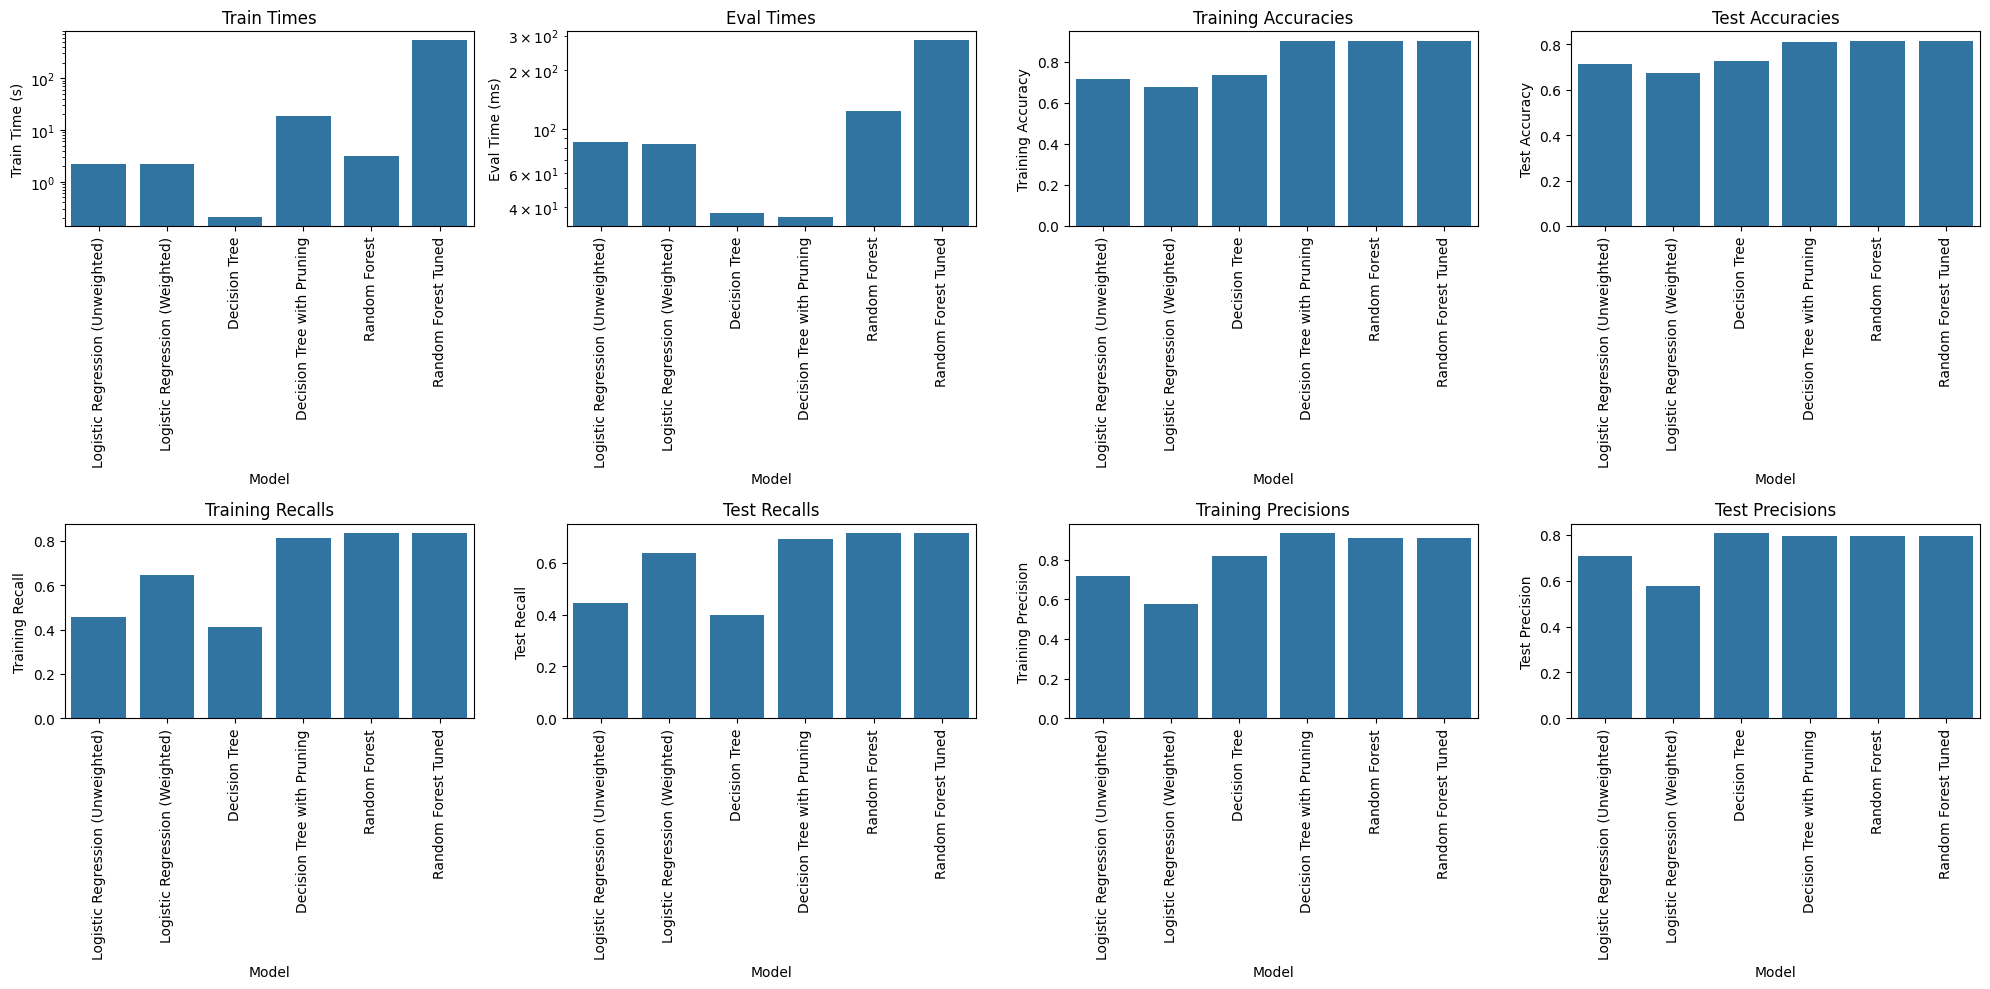

In [ ]:
# Plot column charts of train times, eval times, etc.
train_times_df = pd.DataFrame({'Model': models, 'Train Time (s)': train_times})
eval_times_df = pd.DataFrame({'Model': models, 'Eval Time (ms)': eval_times})
train_accuracies_df = pd.DataFrame({'Model': models, 'Training Accuracy': train_accuracies})
train_recalls_df = pd.DataFrame({'Model': models, 'Training Recall': train_recalls})
train_precisions_df = pd.DataFrame({'Model': models, 'Training Precision': train_precisions})
test_accuracies_df = pd.DataFrame({'Model': models, 'Test Accuracy': test_accuracies})
test_recalls_df = pd.DataFrame({'Model': models, 'Test Recall': test_recalls})
test_precisions_df = pd.DataFrame({'Model': models, 'Test Precision': test_precisions})

plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
sns.barplot(x='Model', y='Train Time (s)', data=train_times_df)
plt.yscale('log')
plt.title('Train Times')
plt.xlabel('Model')
plt.ylabel('Train Time (s)')
plt.xticks(rotation=90)

#log scale the y axis for this one
plt.subplot(2, 4, 2)
sns.barplot(x='Model', y='Eval Time (ms)', data=eval_times_df, log_scale=True)
plt.yscale('log')
plt.title('Eval Times')
plt.xlabel('Model')
plt.ylabel('Eval Time (ms)')
plt.xticks(rotation=90)

plt.subplot(2, 4, 3)
sns.barplot(x='Model', y='Training Accuracy', data=train_accuracies_df)
plt.title('Training Accuracies')
plt.xlabel('Model')
plt.ylabel('Training Accuracy')
plt.xticks(rotation=90)

plt.subplot(2, 4, 4)
sns.barplot(x='Model', y='Test Accuracy', data=test_accuracies_df)
plt.title('Test Accuracies')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=90)

plt.subplot(2, 4, 5)
sns.barplot(x='Model', y='Training Recall', data=train_recalls_df)
plt.title('Training Recalls')
plt.xlabel('Model')
plt.ylabel('Training Recall')
plt.xticks(rotation=90)

plt.subplot(2, 4, 6)
sns.barplot(x='Model', y='Test Recall', data=test_recalls_df)
plt.title('Test Recalls')
plt.xlabel('Model')
plt.ylabel('Test Recall')
plt.xticks(rotation=90)

plt.subplot(2, 4, 7)
sns.barplot(x='Model', y='Training Precision', data=train_precisions_df)
plt.title('Training Precisions')
plt.xlabel('Model')
plt.ylabel('Training Precision')
plt.xticks(rotation=90)

plt.subplot(2, 4, 8)
sns.barplot(x='Model', y='Test Precision', data=test_precisions_df)
plt.title('Test Precisions')
plt.xlabel('Model')
plt.ylabel('Test Precision')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

We can see a few things right from the beginning. First, the decision tree with pruning and hyperparameter tuned random forest take the longest to train by a large margin, most likely due to the hyperparameter tuning, but the decision tree models are the fastest at evaluating, while the two random forest models are the slowest at evaluating.

In terms of accuracy, precision, and recall, we can see that the random forest classifier with tuning has the highest accuracy and recall, and it is the second highest for precision behind the decision tree without pruning. All of our advanced models show improvements over the baseline models in terms of test precision and test accuracy, and most of the models also perform better than the baseline models in terms of recall.

In terms of our recommendation, we recommend the random forest classifier with tuning. This has the highest precision, while it also has high accuracy and recall. Even though this takes a long time to train and is the slowest at evaluation, it is by far the best models in terms of accuracy, precision, and recall. However, if time is a very valuable resource and the hotel doesn't have enough time to train and evaluate the model, the random forest classifier without tuning is faster to train and evaluate, and the cost in terms of accuracy, recall, and precision isn't too large.

## Hypothesis Testing

### Do City Hotels Have Higher Cancellation Rates?



Our test statistic will be the difference in cancellation rates between City Hotels and Resort Hotels.

In [ ]:
# Overall Cancellation rate
overall_cancellation_rate = hotel_bookings_df['is_canceled'].mean()
# Calculate cancellation rate for City Hotels
city_hotel_df = hotel_bookings_df[hotel_bookings_df['hotel'] == 'City Hotel']
cancellation_rate_city_hotel = city_hotel_df['is_canceled'].mean()
# Calculate cancellation rate for Resort Hotels
resort_hotel_df = hotel_bookings_df[hotel_bookings_df['hotel'] == 'Resort Hotel']
cancellation_rate_resort_hotel = resort_hotel_df['is_canceled'].mean()
test_stat = cancellation_rate_city_hotel - cancellation_rate_resort_hotel
print(f"Overall Cancellation Rate for {len(hotel_bookings_df)} hotels: {overall_cancellation_rate}")
print(f"Cancellation rate for {len(city_hotel_df)} City Hotels: {cancellation_rate_city_hotel}")
print(f"Cancellation rate for {len(resort_hotel_df)} Resort Hotels: {cancellation_rate_resort_hotel}")
print(f"Difference between City Hotel CR and Resort Hotel CR: {test_stat}")

Overall Cancellation Rate for 102713 hotels: 0.38923992094476845
Cancellation rate for 71001 City Hotels: 0.426712299826763
Cancellation rate for 31712 Resort Hotels: 0.3053418264379415
Difference between City Hotel CR and Resort Hotel CR: 0.12137047338882151


As seen from the above print statements, the observed test statistic in our dataset is 12.1%.

Our Null Hypothesis is the hotel type has no effect, which means City Hotels and Resort hotels both have a cancellation rate = 38.9% (overall cancellation rate).

We will simulate the null hypothesis over 10,000 trials and plot the test statistics for these 10,000 trials.

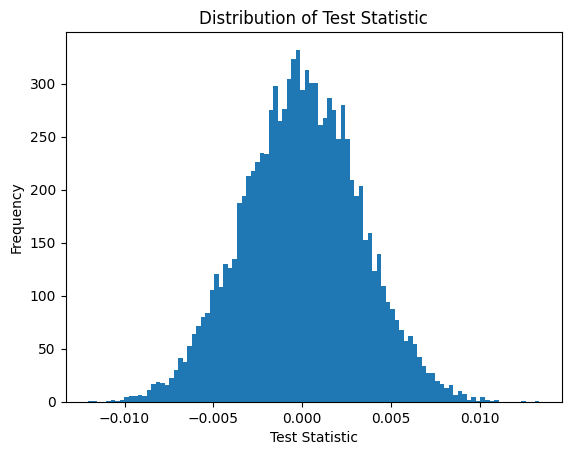

In [ ]:
import random
random.seed(42)

all_ts = []
for i in range(10_000):
  is_canceled = np.random.binomial(1, overall_cancellation_rate, len(hotel_bookings_df))
  g1 = is_canceled[:len(city_hotel_df)]
  g2 = is_canceled[len(city_hotel_df):]
  ts = np.mean(g1) - np.mean(g2)
  all_ts.append(ts)

_ = plt.hist(all_ts, bins=100)
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Distribution of Test Statistic')
plt.show()

As seen from the above plot, the test statistic for the 10,000 null hypothesis simulations rarely goes over 1%, which means our observed test statistic over 12.1% is very strong.

Calculating the empiricial p-value:

In [ ]:
# Calculate empirical p value
p_value = np.mean(np.abs(all_ts) >= test_stat)
print(f"Empirical p-value: {p_value}")

Empirical p-value: 0.0


Becuase we performed 10,000 trials, we can say our empirical p-value must be less than 1/10,000. Therefore, we can reject the null hypothesis.

# Results

 Both decision trees and random forest classifiers were more accurate than the baseline models.

 The model that performed the best overall was the tuned random forest classifier, as it had the best test accuracy and recall and its precision was only around 1% less than the decision tree's precision. However, if training time were a concern, a random forest classifier without tuning would be better because it provides much faster training time at the expense of 0.1% to 0.2% less accuracy, precision, and recall.

 Additionally, we can tested hypothesis of city hotels having higher cancellation rates than resort hotels using simulation and obtain an empirical p-value of < 1/10,000, which means our hypothesis is very strong and it is very likely that city hotels have higher cancellation rates than resort hotels.

# Conclusion

**Important Features**
- **Market Segment**: Group market segments, which is often for many hotel bookings for large events like weddings, have a significantly higher cancellation rate because people often aren't able to make it or the entire event is canceled.
- **Customer Type**: Transient customers, which are guests who book at non-group and non-negotiated rates, are more likely to cancel because they have more flexibility when booking alone. On the other hand, group customer types, which are small groups of guests who group together at a discounted rate, have less cancellation because there is less flexibility when booking with a group.
- **Lead Time**: the further back a guest makes a booking, the more time they have to cancel or for plans to change.
- **Hotel Type**: As seen from our hypothesis testing, it is very likely that city hotels have a higher cancellation rate than resort hotels. This could be because there are more hotels in cities, so guests have more options to choose and switch between.
- **Booking Changes**: More booking changes leads to less cancellations. This is because more booking changes implies that the hotel is more flexible for their customer, incentivizing customers to not cancel.

**Factors that improved model performance**
- Hyperparameter tuning enabled us to find the optimal parameters to maximize accuracy, precision, and recall.

**Modeling implications for potential stakeholders**
- City hotels should be prepared to adapt to higher cancellation rates
- All hotels should expect a lot of cancellation activity from group market segment bookings like weddings and dinners
- To reduce cancellation rates, hotels should provide flexible booking policies, so guests can make more booking changes instead of canceling their booking, and encourage guests to book together in small groups.

**Model limitations**
- The dataset did not explain what a lot of the features meant. As a result, we had to drop some of the features.
- Some features were very unbalanced. For example, some market segments were much more prevalent than others.
- Timescope limited to be between 2015 and 2017, so the model doesn't capture recent cancellation trends.

**Potential improvement (other models to test or data to add) / future work**
- Adding more data (to account for unbalanced market segment data)
- Filtering by country (countries often have specific trends)
- Using other models such as neural networks (for better prediction)
- See how hotel cancellation rate changes over time (use a dataset that goes beyond 2015 to 2017)
